In [41]:
cd ~/gitprojects/yolox/

/home/av/gitprojects/yolox


In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# !nvidia-smi

In [44]:
im_size = 64
bz = 32

# Imports

In [45]:
__author__ = 'anhvo'

import os
import mmcv
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from avcv.visualize import *
from avcv.utils import images_to_video, put_text
import numpy as np
import cv2
from pycocotools.coco import COCO
real_rot_bbox = COCO('/home/av/data/compressed_all_desay/train.json')


loading annotations into memory...
Done (t=4.63s)
creating index...
index created!


In [46]:
num_ann_real = len(real_rot_bbox.dataset['annotations'])

# Input target

## Visualize random inputs

In [47]:
idx = np.random.choice(num_ann_real)

Training at size: (64, 64)


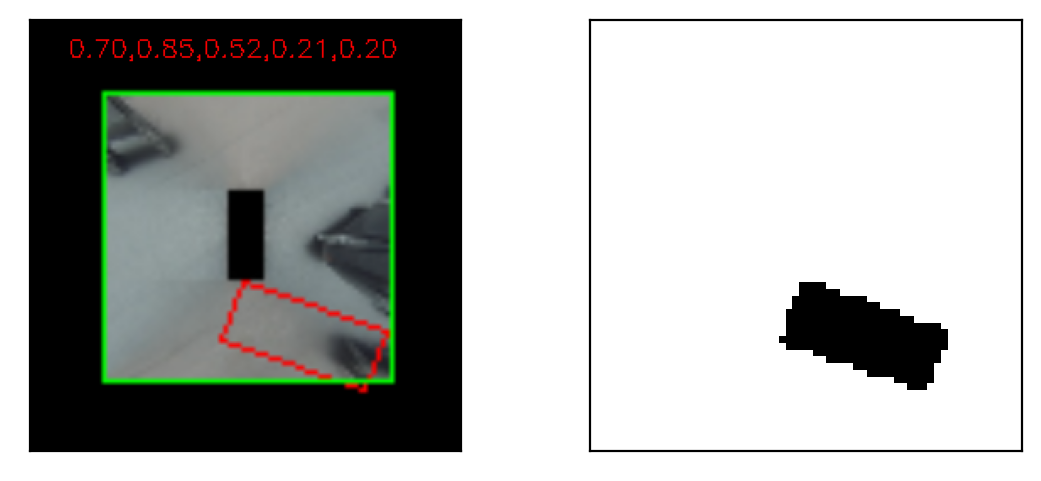

In [48]:
# from iou_loss.iou_loss_model import *
from yolox.models.riou_loss.iou_loss_model import *
ip = InputTarget()


ann = real_rot_bbox.anns[idx]

img_id = real_rot_bbox.getImgIds(ann['image_id'])[0]

img = real_rot_bbox.imgs[img_id]

rbox = coco_segmentation_to_rbox(ann['segmentation'])
# assert rbox[2] < 90

ip.set_input(normalize_input(rbox, img['width'], img['height']))
ip.show(50, "/home/av/data/compressed_all_desay/image/"+img['file_name']);

In [49]:
# from iou_loss.iou_loss_model import *
from yolox.models.riou_loss.iou_loss_model import *
ip = InputTarget()
angles = []
for idx in range(num_ann_real):
    ann = real_rot_bbox.anns[idx]

    img_id = real_rot_bbox.getImgIds(ann['image_id'])[0]

    img = real_rot_bbox.imgs[img_id]

    rbox = coco_segmentation_to_rbox(ann['segmentation'])

    angles.append(rbox[2])

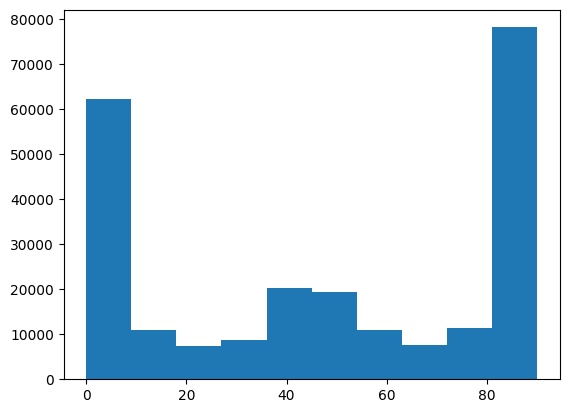

In [50]:
import matplotlib.pyplot as plt
plt.hist(np.array(angles))
plt.show()

# DATASET

In [51]:
from avcv.process import multi_thread

In [53]:
class RotDS(torch.utils.data.Dataset):
    def __init__(self, n, repeat=10):
        self.ip = InputTarget()
        self.n = n
        self.repeat = repeat
        self.cache = []
    
    def __len__(self):
        return self.n*self.repeat
    
    def get_input(self, index):
        if np.random.choice(2):
            cx = np.random.uniform(0., 0.8)
            cy = np.random.uniform(0., 0.8)
            h = np.random.uniform(0.08, 0.5)
            w = np.random.uniform(0.08, 0.5)
            
            a = np.random.uniform(0, 1)
            self.ip.set_input([cx, cy, w, h, a])
            target = self.ip.target
            input, target = self.ip.input.astype(np.float32), target.astype(np.float32)
        else:
            idx = np.random.choice(num_ann)
            ann = real_rot_bbox.anns[idx]

            img_id = real_rot_bbox.getImgIds(ann['image_id'])[0]

            img = real_rot_bbox.imgs[img_id]

            rbox = coco_segmentation_to_rbox(ann['segmentation'])

            ip.set_input(normalize_input(rbox, img['width'], img['height']))
            target = ip.target
            input, target = ip.input.astype(np.float32), target.astype(np.float32)
            
        return input, target

    
    def __getitem__(self, index):
        index = index%self.n
        item = None
        while item is None:
            try:
                item = self.get_input(index)
            except:
                pass
        return item
        


(4, 4)


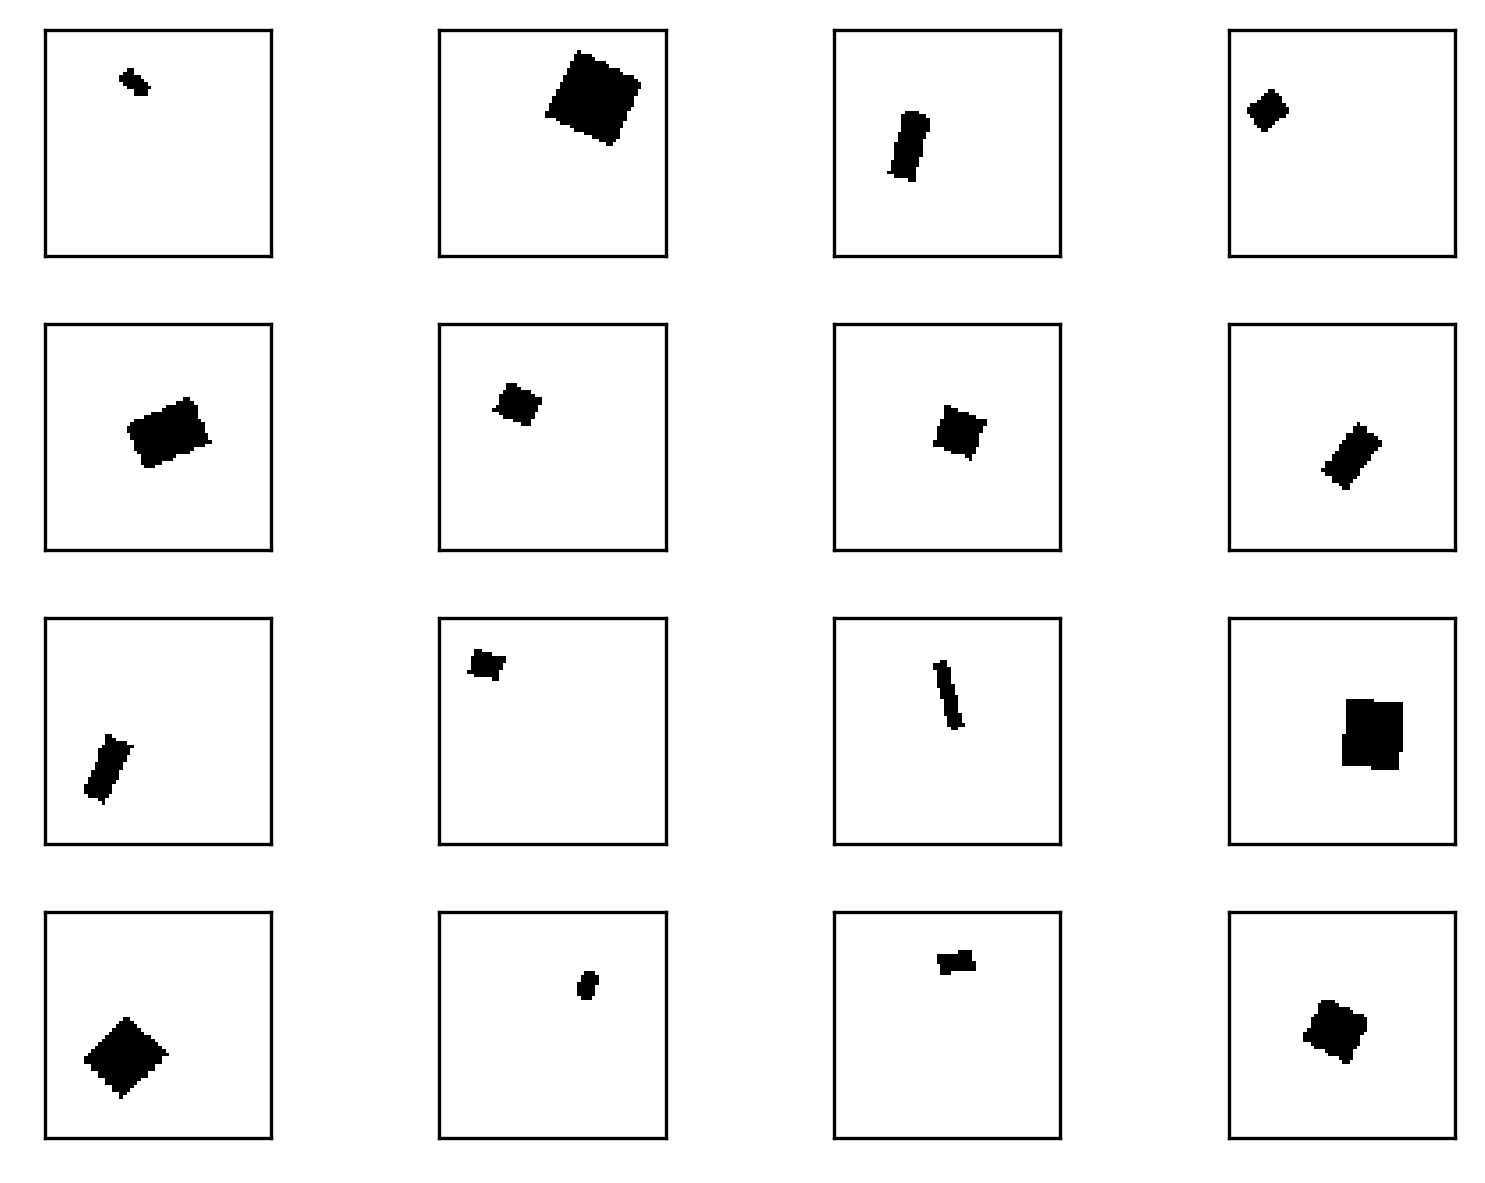

In [54]:
val_loader = torch.utils.data.DataLoader(RotDS(n=16), 16, shuffle=True, num_workers=1)
for sample_inputs, sample_targets in val_loader:break
plot_images(sample_targets, dpi=300)

# LOSSES

In [55]:
from typing import Optional, List

import torch
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

BINARY_MODE: str = "binary"
 
MULTICLASS_MODE: str = "multiclass"


MULTILABEL_MODE: str = "multilabel"

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.array(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x


def soft_dice_score(
        output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score
    
    
class DiceLoss(_Loss):

    def __init__(
        self,
        mode: str,
        classes: Optional[List[int]] = None,
        log_loss: bool = False,
        from_logits: bool = True,
        smooth: float = 0.0,
        ignore_index: Optional[int] = None,
        eps: float = 1e-7,
    ):
        """Implementation of Dice loss for image segmentation task.
        It supports binary, multiclass and multilabel cases

        Args:
            mode: Loss mode 'binary', 'multiclass' or 'multilabel'
            classes:  List of classes that contribute in loss computation. By default, all channels are included.
            log_loss: If True, loss computed as `- log(dice_coeff)`, otherwise `1 - dice_coeff`
            from_logits: If True, assumes input is raw logits
            smooth: Smoothness constant for dice coefficient (a)
            ignore_index: Label that indicates ignored pixels (does not contribute to loss)
            eps: A small epsilon for numerical stability to avoid zero division error 
                (denominator will be always greater or equal to eps)

        Shape
             - **y_pred** - torch.Tensor of shape (N, C, H, W)
             - **y_true** - torch.Tensor of shape (N, H, W) or (N, C, H, W)

        Reference
            https://github.com/BloodAxe/pytorch-toolbelt
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss
        self.ignore_index = ignore_index

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:

        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = self.compute_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return self.aggregate_loss(loss)

    def aggregate_loss(self, loss):
        return loss.mean()

    def compute_score(self, output, target, smooth=0.0, eps=1e-7, dims=None) -> torch.Tensor:
        return soft_dice_score(output, target, smooth, eps, dims)

# Model 

In [57]:
from yolox.models.riou_loss.riou_loss import IoULossModel

# Trainer 

In [58]:
model = IoULossModel().cuda()

In [19]:
import pytorch_lightning as pl

dice_loss = DiceLoss(mode='binary')
def compute_loss(preds, targets):
    target_h, target_w = targets.shape[-2:]
    preds = nn.functional.interpolate(preds, (target_h, target_w))
    return dice_loss(preds, targets.cuda().long())

class LitModel(pl.LightningModule):
    def __init__(self, model, learning_rate=0.02, batch_size=1024,num_samples=20000):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_samples = num_samples
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(RotDS(n=self.num_samples, repeat=100), self.batch_size, shuffle=True, num_workers=3)
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        di_loss = compute_loss(y_hat, y)#nn.functional.binary_cross_entropy(y_hat.reshape(-1), y.reshape(-1))
        bi_loss = nn.functional.binary_cross_entropy(y_hat.reshape(-1), y.reshape(-1))

        return bi_loss+di_loss
    def loss(self, preds, targets):
        return compute_loss(preds, targets)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)   

# Training 

In [20]:
# val_loader = torch.utils.data.DataLoader(RotDS(n=16), 16, shuffle=True, num_workers=8)

# for sample_inputs, sample_targets in val_loader:break

# plot_images(sample_targets)

In [151]:
model.load_state_dict(torch.load("last.pth"))
lit_model = LitModel(model, learning_rate=10e-4, batch_size=1024)
model.train()
trainer = pl.Trainer(gpus=[4,5,6,7], accelerator='dp', auto_lr_find=True, max_epochs=100)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 4.2 M 
--------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.984    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

/home/av/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainer.fit(lit_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 4.2 M 
--------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.984    Total estimated model params size (MB)


Training: 37it [00:00, ?it/s]

In [152]:
# for epoch in range(100):
#     lit_model = LitModel(model, learning_rate=10e-4, batch_size=1024)
#     model.train()
#     trainer = pl.Trainer(gpus=[4,5,6,7], accelerator='dp', auto_lr_find=True, max_epochs=1)
#     trainer.fit(lit_model)
    


# Visualize

In [22]:
model = IoULossModel()
model.load_state_dict(torch.load("./weights/iou_loss_model/last.pth"))

<All keys matched successfully>

In [23]:
inputs = []
targets = []
rboxes = []

for idx in np.random.choice(len(real_rot_bbox.anns), 32):
    ann = real_rot_bbox.anns[idx]
    img_id = real_rot_bbox.getImgIds(ann['image_id'])[0]
    img = real_rot_bbox.imgs[img_id]

    rbox = coco_segmentation_to_rbox(ann['segmentation'])
    rboxes.append(rbox)
    ip.set_input(normalize_input(rbox, img['width'], img['height']))
    inputs.append(ip.input)
    targets.append(ip.target)
inputs = np.array(inputs)
targets = np.array(targets)


In [24]:
# !mkdir weights/iou_loss_model/

In [25]:
# torch.save(model.state_dict(), "./weights/iou_loss_model/last.pth")

In [ ]:
model.eval()
with torch.no_grad():
    out = model(torch.from_numpy(inputs)).squeeze().numpy()
plot_images(np.concatenate([out, targets], 2))

In [167]:
# class RIoULoss(nn.Module):
#     def __init__(self, img_w, img_h):
#         super().__init__()
#         self.model = IoULossModel()
#         self.model.load_state_dict(torch.load("./weights/iou_loss_model/last.pth"))
#         self.img_w = img_w
#         self.img_h = img_h
#         self.loss_fn = nn.functional.binary_cross_entropy
        
#     def forward(self, pred, target):
#         bz = len(pred)
#         _pred = normalize_input(pred, self.img_w, self.img_h, mode='batch_rbox') 
#         _target = normalize_input(target, self.img_w, self.img_h, mode='batch_rbox')
#         with torch.no_grad():
#             mask_pred = model(torch.Tensor(_pred)).reshape(bz, -1)
#             mask_target = (model(torch.Tensor(_target)).reshape(bz, -1) > 0.5).float()
            
#         return self.loss_fn(mask_pred, mask_target, reduction='none')    
from iou_loss.loss_fn import RIoULoss

In [173]:
target = torch.Tensor([[ 68.7500, 326.2500,  92.5303, 140.8923,  87.9546],
        [417.5000, 306.2500,  87.4514, 152.9984,  88.0909],
        [ 70.0000, 423.7500,  99.8568, 145.5502,  86.9335],
        [417.5001, 477.5000,  81.9056, 155.9374,  83.1183],
        [418.7500, 563.7499,  94.2398, 150.6033,  82.7468],
        [ 70.0000, 522.5001, 107.4829, 141.9416,  88.9770],
        [497.1543, 349.5916, 173.7484,  66.7359,  65.6954],
        [433.7500, 386.2500, 180.5368,  80.1185,  65.3441],
        [366.2500, 427.5000, 186.1938,  85.8086,  65.9558],
        [291.8518, 472.9734, 194.0327,  90.8064,  67.2490],
        [205.0000, 518.7499, 208.1914, 105.4162,  68.0615],
        [106.5205, 558.7157, 200.1406, 114.1698,  69.5277],
        [382.2371, 234.0318, 265.6313,  85.9587,   3.7314],
        [323.7421, 152.6400, 316.7758,  67.6181,   3.2155],
        [431.2234, 321.7304, 163.8652,  90.9508,   0.8814],
        [ 88.3092, 446.2344, 112.4883, 204.4658,  78.0031],
        [150.6685, 550.7505, 115.2268, 286.9776,  79.0278],
        [ 82.5001, 167.5000, 165.0000, 105.0000, 180.0000],
        [ 81.2500, 523.7499, 102.5000, 162.5000,  90.0000],
        [ 81.2500, 523.7499, 102.5000, 162.5000,  90.0000],
        [ 82.5001, 167.5000, 165.0000, 105.0000, 180.0000],
        [347.5000, 250.0000, 251.9662,  80.2376,  92.3137]])

pred = torch.Tensor([[ 9.4363e+01,  2.8531e+02,  3.6323e+01,  2.9997e+01, -3.7204e-02],
        [ 4.1174e+02,  3.1772e+02,  3.7410e+01,  3.1251e+01,  1.1327e-01],
        [ 9.4380e+01,  3.8211e+02,  3.6261e+01,  3.2135e+01, -1.6295e-02],
        [ 4.1326e+02,  4.4275e+02,  3.8212e+01,  3.1989e+01, -3.6888e-02],
        [ 4.4622e+02,  5.0814e+02,  3.7481e+01,  3.0930e+01,  1.8023e-02],
        [ 9.2034e+01,  5.7502e+02,  3.7940e+01,  3.2163e+01,  1.0471e-01],
        [ 4.7731e+02,  3.4527e+02,  3.7977e+01,  3.0525e+01, -2.1388e-02],
        [ 4.4515e+02,  3.7920e+02,  3.8991e+01,  3.0477e+01, -4.0742e-02],
        [ 2.9740e+02,  4.4229e+02,  3.4634e+01,  4.9182e+01, -1.0567e+00],
        [ 2.2277e+02,  4.7517e+02,  3.7720e+01,  4.6197e+01, -4.4317e-01],
        [ 2.3921e+02,  5.1862e+02,  4.2270e+01,  4.0375e+01, -6.2151e-01],
        [ 1.0165e+02,  5.8849e+02,  3.6846e+01,  5.0258e+01,  1.8024e-01],
        [ 3.9237e+02,  2.1832e+02,  5.0647e+01,  6.0880e+01,  1.0135e-01],
        [ 3.2685e+02,  1.3487e+02,  5.4736e+01,  4.3475e+01, -3.4024e-01],
        [ 4.4167e+02,  3.1307e+02,  4.2298e+01,  4.5537e+01, -4.3206e-01],
        [ 1.2635e+02,  4.5070e+02,  3.9212e+01,  3.4279e+01, -8.8215e-02],
        [ 1.2173e+02,  5.1639e+02,  4.6158e+01,  3.2811e+01, -3.1597e-01],
        [ 2.1231e+01,  1.6794e+02,  1.2147e+02,  1.0382e+02, -1.8443e+00],
        [ 9.6482e+01,  4.7620e+02,  1.5057e+02,  6.2426e+01, -2.8597e+00],
        [ 5.1538e+01,  5.3538e+02,  1.2728e+02,  3.4302e+02,  1.1684e+00],
        [ 3.1048e+01,  1.7628e+02,  1.3022e+02,  9.2944e+01, -4.1313e+00],
        [ 3.3146e+02,  2.7195e+02,  4.8248e+01,  3.9216e+01,  5.8420e-01]])


In [174]:
riou_loss = RIoULoss(640, 640)

In [175]:
riou_loss(pred, target).mean(1)

tensor([0.2473, 0.3136, 0.3819, 0.1771, 0.7727, 0.9045, 0.2690, 0.3249, 0.5769,
        0.8483, 0.8799, 1.1415, 0.4870, 0.6617, 0.1860, 0.8468, 1.7755, 0.8363,
        0.4185, 4.4299, 0.8270, 0.4028])